In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [52]:
def load_and_clean_data(folder_path):
    pathlist = Path(folder_path).glob('*.csv')
    comb_data = pd.DataFrame()
    
    for path in pathlist:
        try:
            raw_data = pd.read_csv(str(path))
            reindex_data = raw_data.reset_index()
            reindex_data.columns = ["Account ID", "Service Address", "Day", "Consumption (kWh)", "Temperature(F)"]
            data_clean = reindex_data.drop(0, axis=0)
            data_final = data_clean[["Day", "Consumption (kWh)", "Temperature(F)"]]
            year = ' ' + str(path)[-8:-4]
            data_final['Day'] = pd.to_datetime(data_final['Day'] + year, format='%b %d %Y')
            comb_data = pd.concat([comb_data, data_final], ignore_index=True)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    
    comb_data = comb_data.sort_values(by="Day").reset_index(drop=True)
    return comb_data

In [54]:
def interpolate_data(data):
    # Replace 0 values with NaN for both columns
    data['Temperature(F)'].replace(0, pd.NA, inplace=True)
    data['Consumption (kWh)'].replace(0, pd.NA, inplace=True)

    # Mean interpolation for a series
    def mean_interpolation(series):
        for i in range(len(series)):
            if pd.isna(series.iloc[i]):
                # Define a 3-day forward and backward window
                start_idx = max(i - 3, 0)
                end_idx = min(i + 3 + 1, len(series))
                # Calculate the mean excluding NaN
                mean_value = series.iloc[start_idx:end_idx].dropna().mean()
                series.iloc[i] = mean_value
        return series

    # Apply the mean interpolation to both columns
    data['Temperature(F)'] = mean_interpolation(data['Temperature(F)'])
    data['Consumption (kWh)'] = mean_interpolation(data['Consumption (kWh)'])

    # Fill any remaining NaN values using forward fill or backward fill
    data['Temperature(F)'].fillna(method='ffill', inplace=True)
    data['Temperature(F)'].fillna(method='bfill', inplace=True)
    data['Consumption (kWh)'].fillna(method='ffill', inplace=True)
    data['Consumption (kWh)'].fillna(method='bfill', inplace=True)

    # Ensure numeric conversion
    data['Temperature(F)'] = pd.to_numeric(data['Temperature(F)'], errors='coerce')
    data['Consumption (kWh)'] = pd.to_numeric(data['Consumption (kWh)'], errors='coerce')

    return data

In [56]:
def plot_data(data):
    fig = plt.figure(figsize=(12, 8), dpi=250)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
    
    ax1 = fig.add_subplot(gs[0])
    sns.set_style("whitegrid")
    sns.lineplot(x='Day', y='Temperature(F)', data=data, ax=ax1, color='red', linewidth=2, linestyle='--')
    ax1.set_title('Daily Temperature Changes Over Time', fontsize=16)
    ax1.set_ylabel('Temperature (F)', fontsize=12)
    ax1.grid(True, which='major', axis='y', color='gray', linestyle='-', linewidth=0.7)
    ax1.grid(False, which='major', axis='x')
    ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax1.get_xticklabels(), rotation=45)
    
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    sns.lineplot(x='Day', y='Consumption (kWh)', data=data, ax=ax2, color='blue', linewidth=2)
    ax2.set_title('Daily Energy Consumption Over Time', fontsize=16)
    ax2.set_ylabel('Energy Consumption (kWh)', fontsize=12)
    ax2.xaxis.set_major_locator(plt.MaxNLocator(15))
    ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax2.get_xticklabels(), rotation=45)
    ax2.grid(True, which='major', axis='y', color='gray', linestyle='-', linewidth=0.7)
    ax2.grid(False, which='major', axis='x')
    
    plt.tight_layout()
    plt.show()

In [86]:
def train_and_evaluate_model(data):
    data['DayOfWeek'] = data['Day'].dt.dayofweek
    data['Month'] = data['Day'].dt.month
    data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: x >= 5)
    
    X = data[['Temperature(F)', 'DayOfWeek', 'Month', 'IsWeekend']]
    y = data['Consumption (kWh)']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')
    
    plt.figure(figsize=(10, 6), dpi=250)
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted Energy Consumption')
    plt.xlabel('Time Index')
    plt.ylabel('Consumption (kWh)')
    plt.show()

In [68]:
# Main workflow
folder_path = "/Users/haobo2022/Documents/energy-model-black-box/energy usage data"

In [70]:
data = load_and_clean_data(folder_path)

/var/folders/pp/g7kx8d4j3blghd0n4hn3q0880000gn/T/ipykernel_99576/593182358.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['Day'] = pd.to_datetime(data_final['Day'] + year, format='%b %d %Y')
/var/folders/pp/g7kx8d4j3blghd0n4hn3q0880000gn/T/ipykernel_99576/593182358.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['Day'] = pd.to_datetime(data_final['Day'] + year, format='%b %d %Y')
/var/folders/pp/g7kx8d4j3blghd0n4hn3q0880000gn/T/ipykernel_99576/593182358.py:13: SettingWithCop

In [81]:
data = interpolate_data(data)

/var/folders/pp/g7kx8d4j3blghd0n4hn3q0880000gn/T/ipykernel_99576/3779734836.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[i] = mean_value
/var/folders/pp/g7kx8d4j3blghd0n4hn3q0880000gn/T/ipykernel_99576/3779734836.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[i] = mean_value
/var/folders/pp/g7kx8d4j3blghd0n4hn3q0880000gn/T/ipykernel_99576/3779734836.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

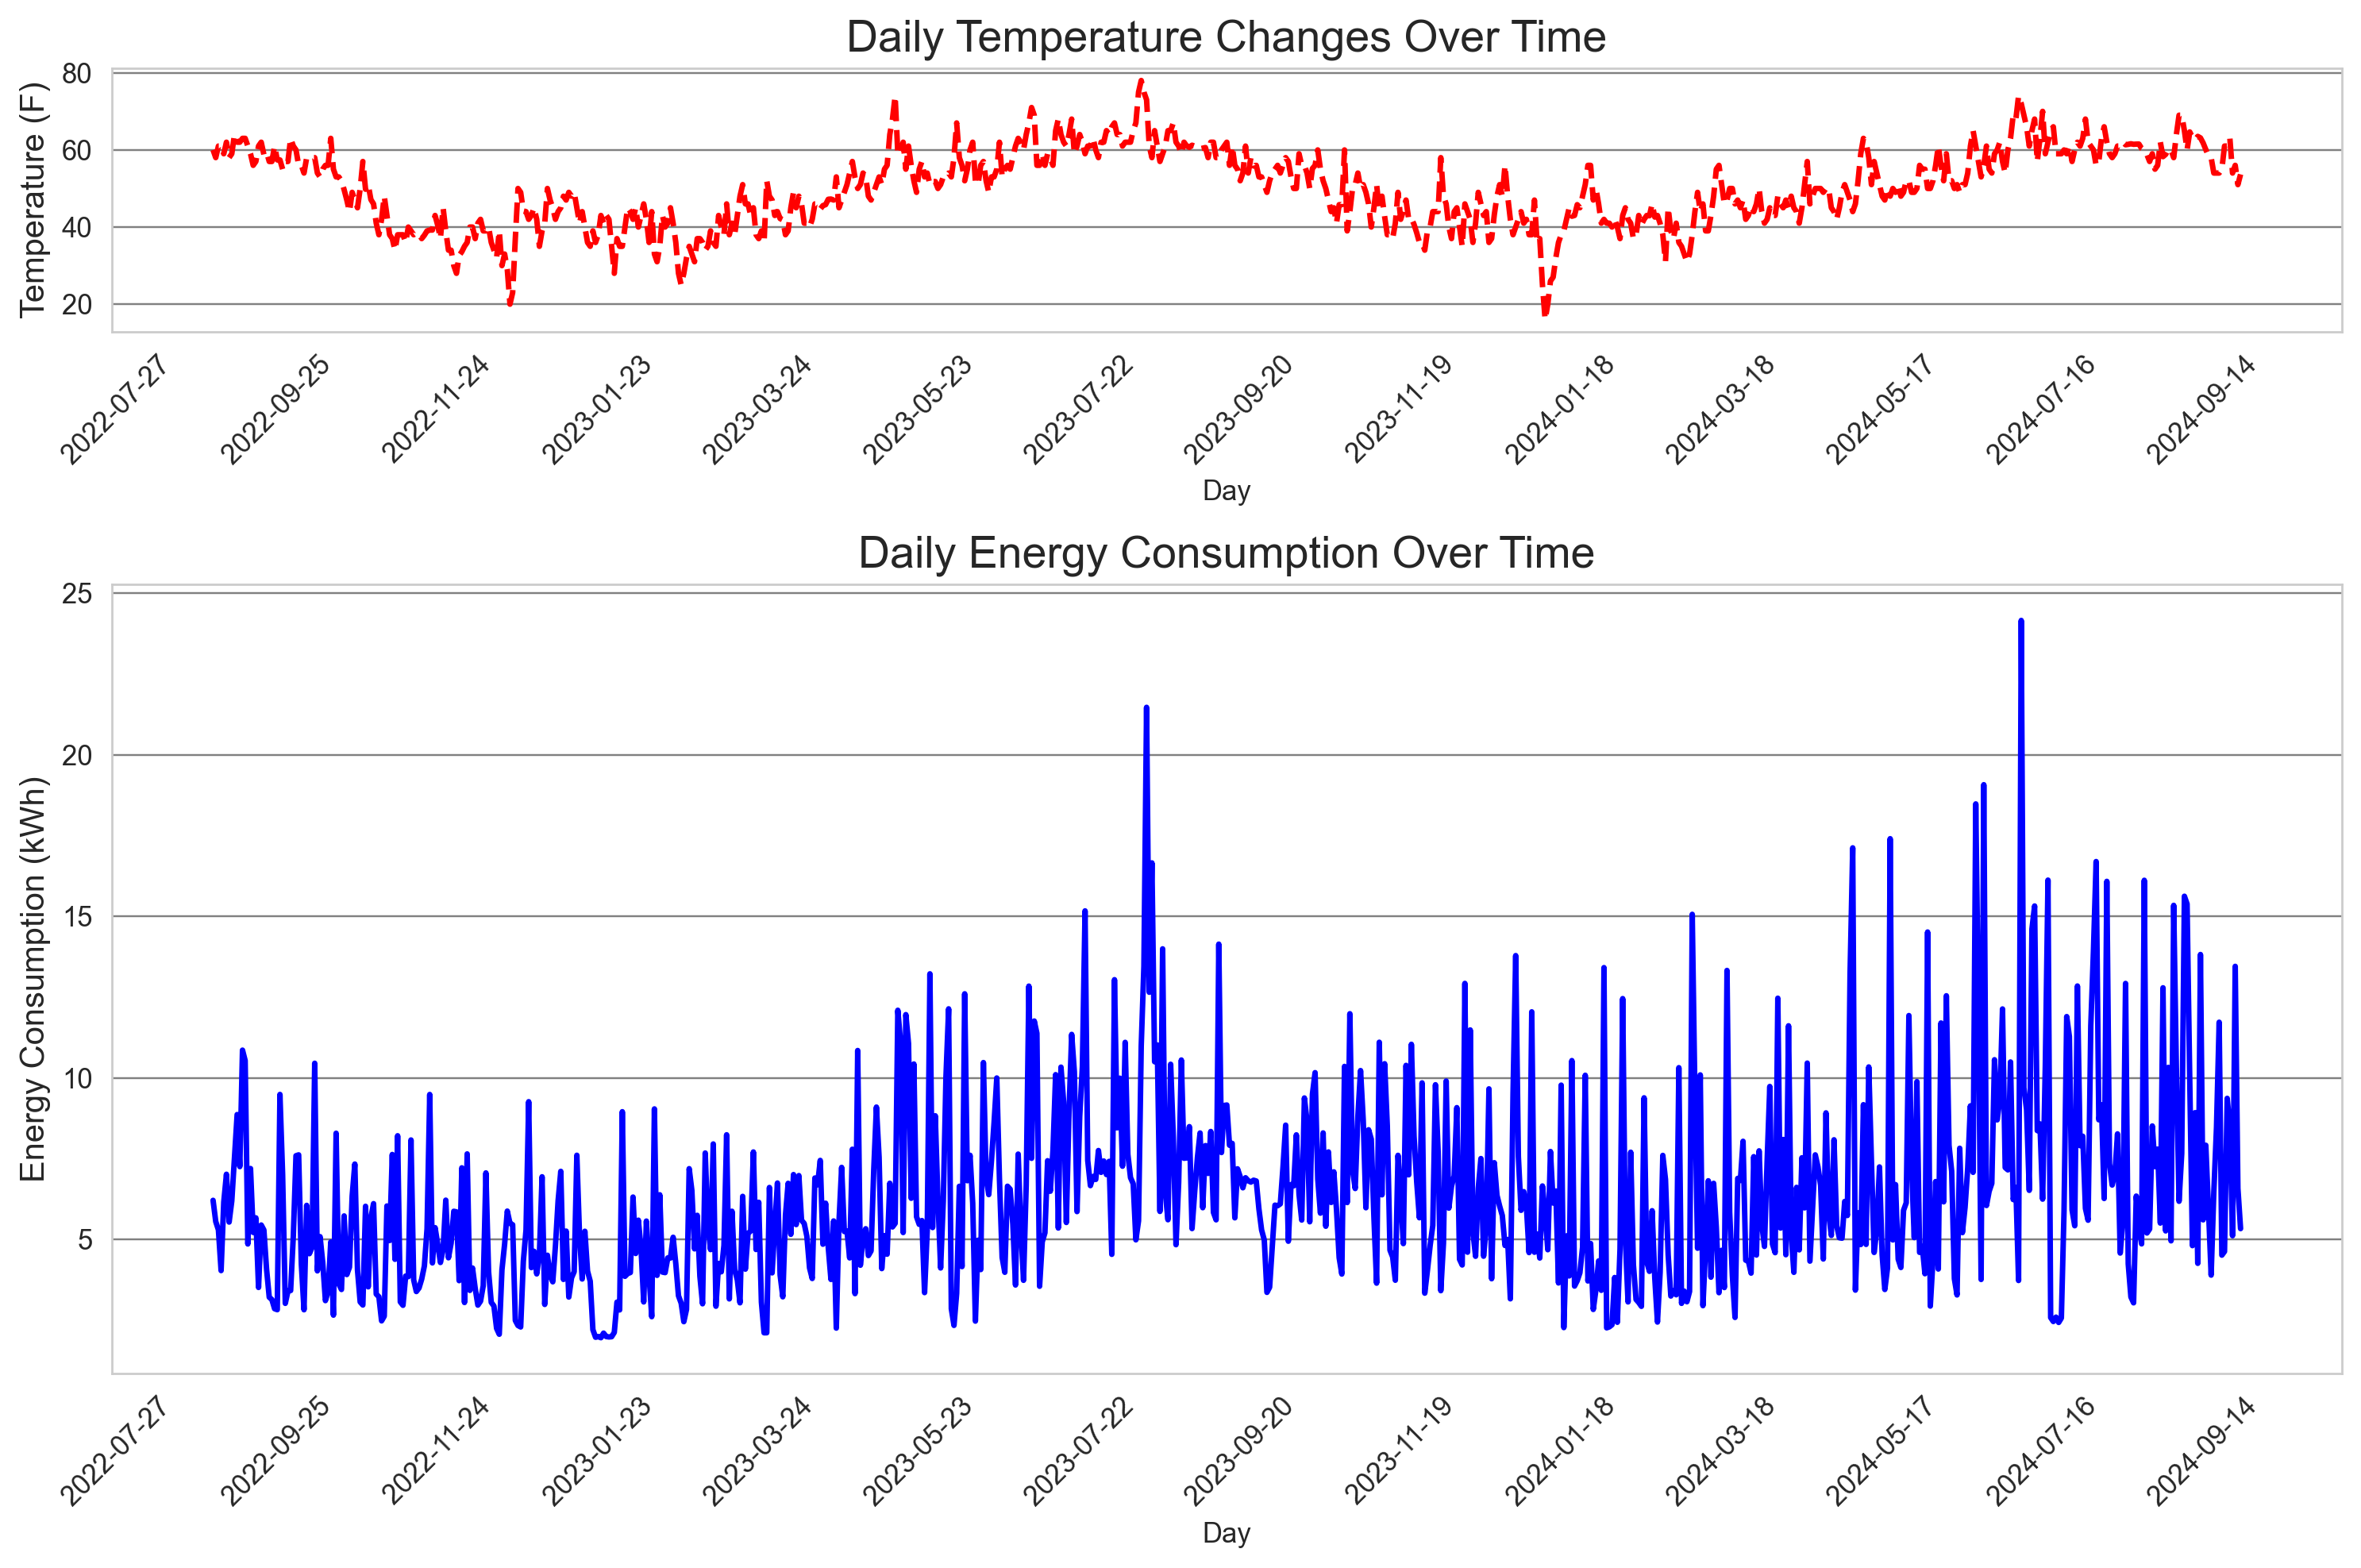

In [83]:
plot_data(data)

Mean Squared Error: 7.612390471156483
R-squared: -0.20988730492595997


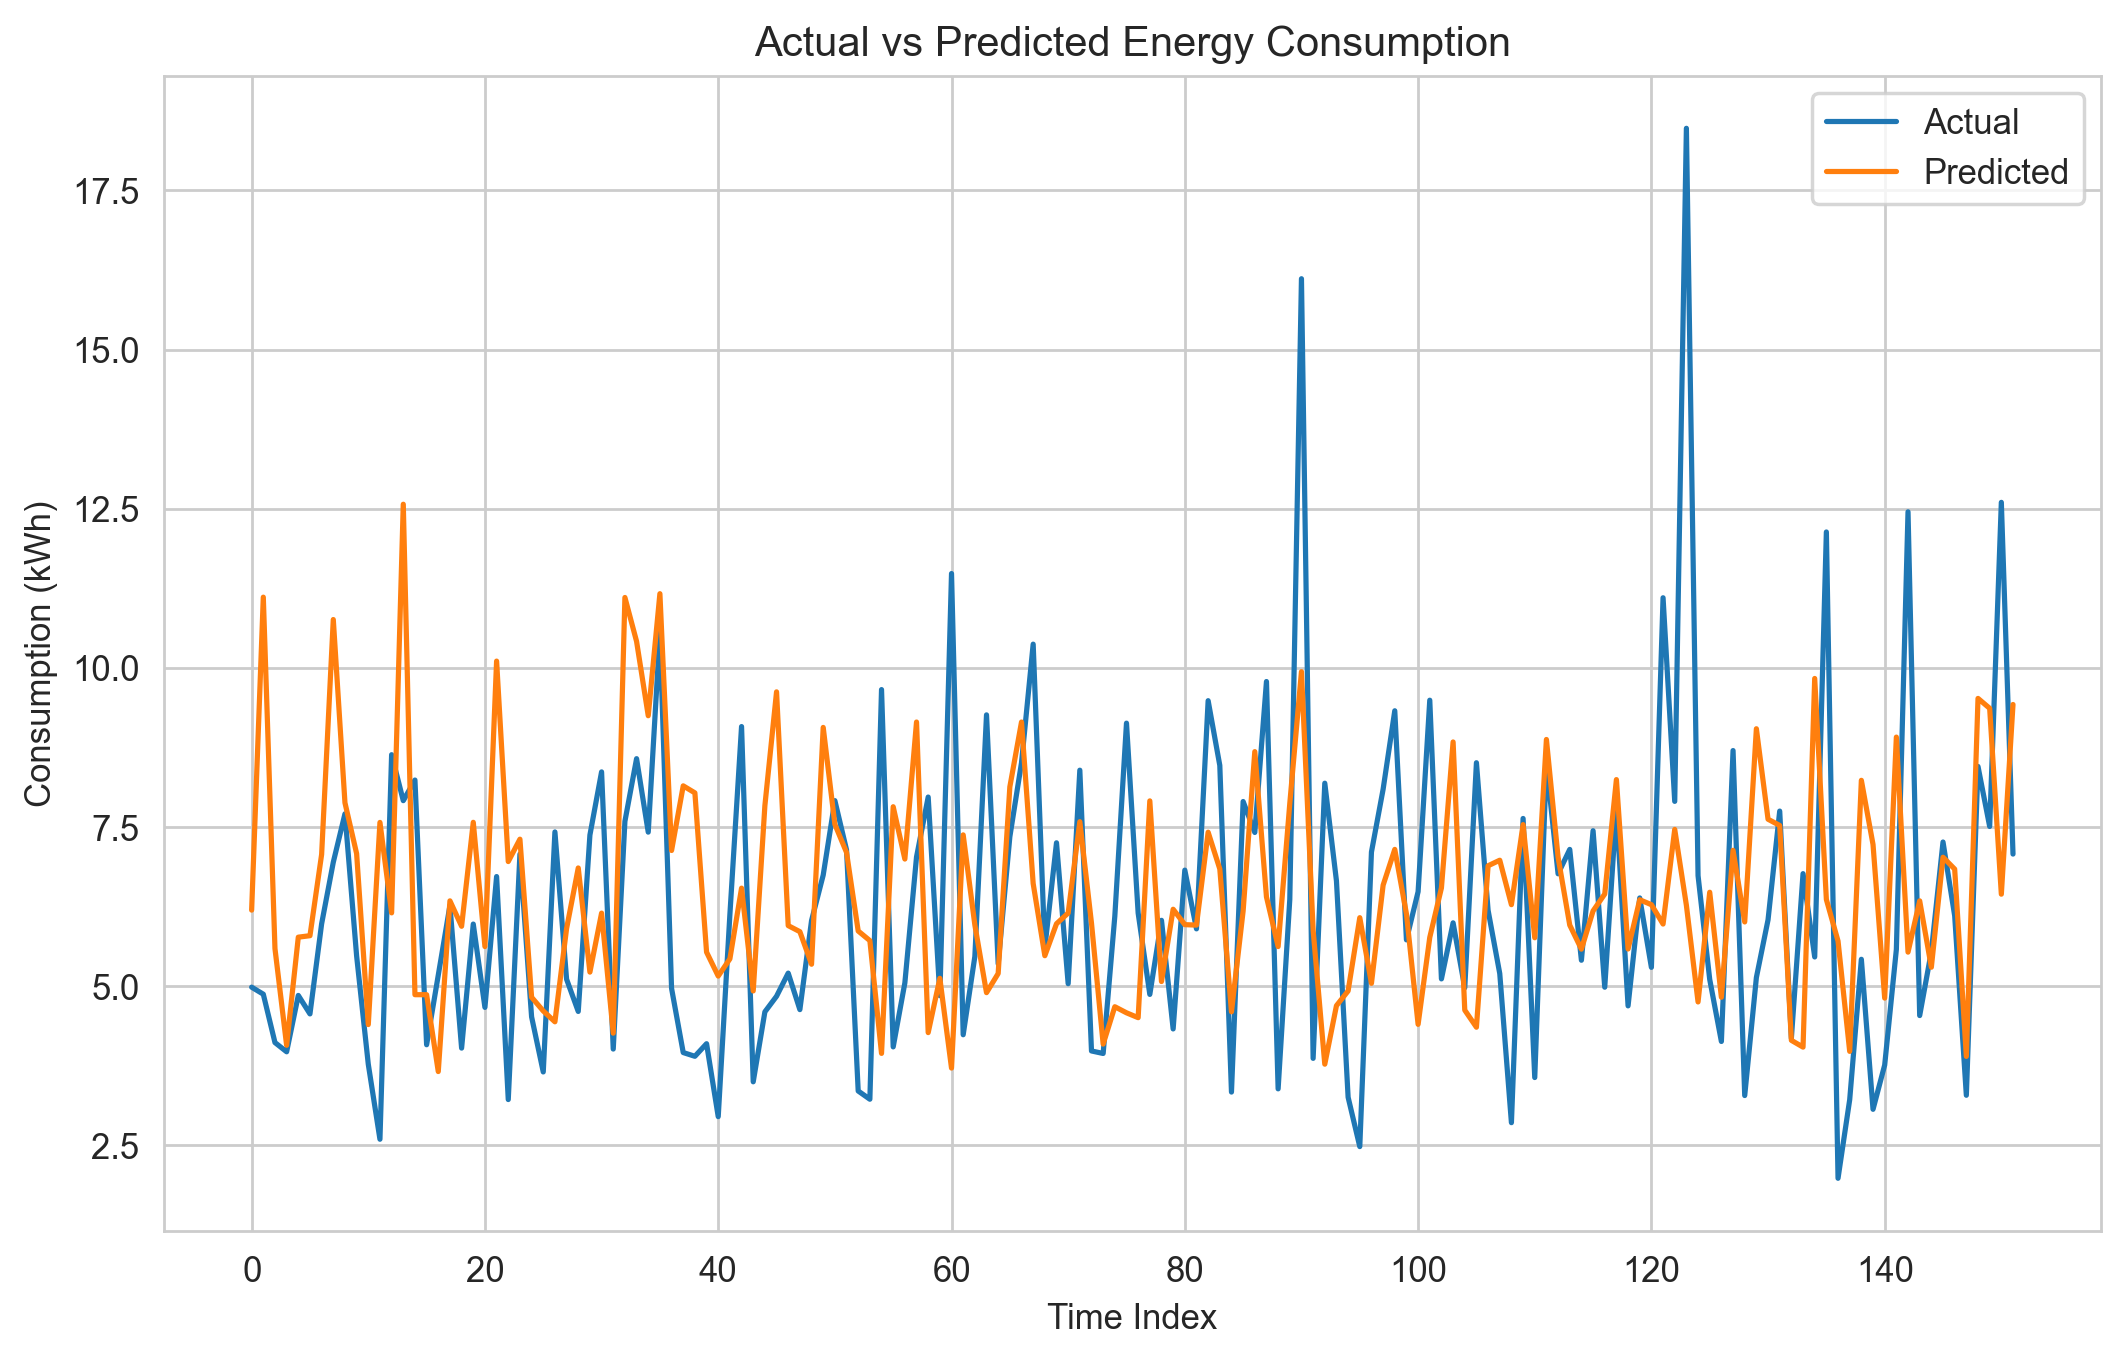

In [88]:
train_and_evaluate_model(data)